# Deep Learning Modell - Swiss Image - Kreisel erkennen

> Leandro Gregorini

## Imports

In [1]:
import os
# Use only CPU
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [2]:
import sys; sys.path.append("/home/gregorleandr@edu.local/projects/CDS108/Aufgabenblatt6/kreisel_deep_learning")  # working dir

In [3]:
# deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from tensorflow import keras
import keras_cv  # for special layers (data augmentation)

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
print(sklearn.show_versions())

# data handling
import math
import numpy as np

# visualisierung
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import seaborn as sns
plt.rcParams['figure.dpi'] = 100

2023-06-12 18:23:12.350562: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 18:23:12.402714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 18:23:13.206892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/home/gregorleandr@edu.local/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



System:
    python: 3.9.16 (main, Mar  8 2023, 14:00:05)  [GCC 11.2.0]
executable: /home/gregorleandr@edu.local/anaconda3/envs/tf_gpu/bin/python
   machine: Linux-5.4.0-149-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.2.2
          pip: 23.1.2
   setuptools: 66.0.0
        numpy: 1.23.5
        scipy: 1.10.1
       Cython: None
       pandas: 1.5.3
   matplotlib: 3.7.1
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /home/gregorleandr@edu.local/anaconda3/envs/tf_gpu/lib/libopenblasp-r0.3.21.so
        version: 0.3.21
threading_layer: pthreads
   architecture: SkylakeX
    num_threads: 64

       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /home/gregorleandr@edu.local/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so
        version: 0.3.18
thre

## Datensatz laden

In [4]:
from dataset import get_train, get_val, get_test

In [5]:
HEIGHT = 1250
WIDTH = 1250

In [6]:
train_generator = get_train('normal')
train_images = train_generator

Found 400 images belonging to 2 classes.


In [7]:
validation_generator = get_val('normal')
val_images = validation_generator

Found 100 images belonging to 2 classes.


In [8]:
test_generator = get_test('normal')
test_images = test_generator

Found 100 images belonging to 2 classes.


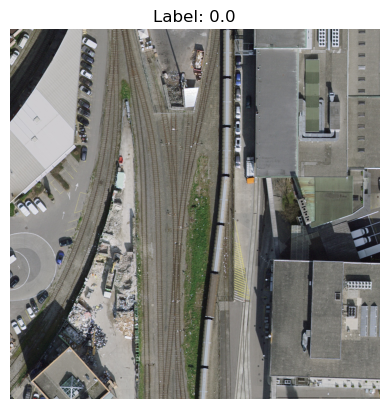

In [9]:
def print_example_image(images):
    batch_images, batch_labels = next(images)  # Get a batch of images and labels

    example_image = batch_images[0]  # Select the first image from the batch
    example_label = batch_labels[0]  # Corresponding label for the first image

    # Display the image and label
    plt.imshow(example_image)
    plt.title('Label: {}'.format(example_label))
    plt.axis('off')
    plt.show()

print_example_image(test_images)

## Funktionen

In [10]:
def plot_scores(model, train_images, test_images, val_images, savefigname=None):
    print("test score:")
    test_results = model.evaluate(test_images)
    test_results = dict(zip(model.metrics_names, test_results))

    print("train score:")
    train_results = model.evaluate(train_images)
    train_results = dict(zip(model.metrics_names, train_results))

    print("val score:")
    val_results = model.evaluate(val_images)
    val_results = dict(zip(model.metrics_names, val_results))

    accuracy = [test_results["accuracy"], train_results["accuracy"], val_results["accuracy"]]
    loss = [test_results["loss"], train_results["loss"], val_results["loss"]]

    X = ["test", "train", "val"]
    X_axis = np.arange(len(X))

    plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'accuracy')
    plt.bar(X_axis + 0.2, loss, 0.4, label = 'loss')

    for i, (x, accuracy, loss) in enumerate(zip(X_axis, accuracy, loss)):
        plt.text(x - 0.25, accuracy + 0.01, str(round(accuracy, 3)), color='blue', fontsize=10)
        plt.text(x + 0.1, loss + 0.01, str(round(loss, 3)), color='orange', fontsize=10)

    plt.xticks(X_axis, X)
    plt.xlabel("Data")
    plt.ylabel("accuracy/loss")
    plt.title("Accuracy/Loss per Data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [11]:
def plot_acc_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['accuracy'])
    plt.plot(trainHistory.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Accuracy")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [12]:
def plot_loss_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['loss'])
    plt.plot(trainHistory.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Loss")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

> https://www.tensorflow.org/tutorials/video/video_classification

In [13]:
def get_actual_predicted_labels(model, dataset, threshold=0.5):
    actual = dataset.classes
    predicted_probabilities = model.predict(dataset)
    predicted_labels = np.where(predicted_probabilities >= threshold, 1, 0)
    predicted = [i[0] for i in predicted_labels]

    return actual, predicted

In [14]:
def plot_confusion_matrix(actual, predicted, ds_type, labels=["n","y"]):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    accuracy = np.trace(cm) / np.sum(cm)
    sns.set(rc={'figure.figsize':(8, 8)})
    ax.set_title('Confusion matrix for ' + ds_type + ' | Accuracy: {:.2%}'.format(accuracy))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

---

## Modellieren

### Base Model

In [15]:
base_model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-06-12 18:23:17.734007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78918 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [16]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1248, 1248, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 624, 624, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 622, 622, 32)      4640      
                                                                 
 flatten (Flatten)           (None, 12380288)          0         
                                                                 
 dense (Dense)               (None, 64)                792338496 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [ ]:
trainHistory = base_model.fit(train_images, epochs=10, validation_data=val_images, verbose=0)

test score:


2023-06-12 18:27:54.002813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step - loss: 1.1687 - accuracy: 0.6300
train score:


2023-06-12 18:28:01.274651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 21s 1s/step - loss: 1.3335e-05 - accuracy: 1.0000
val score:


2023-06-12 18:28:23.384216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 5s 1s/step - loss: 1.2557 - accuracy: 0.5800


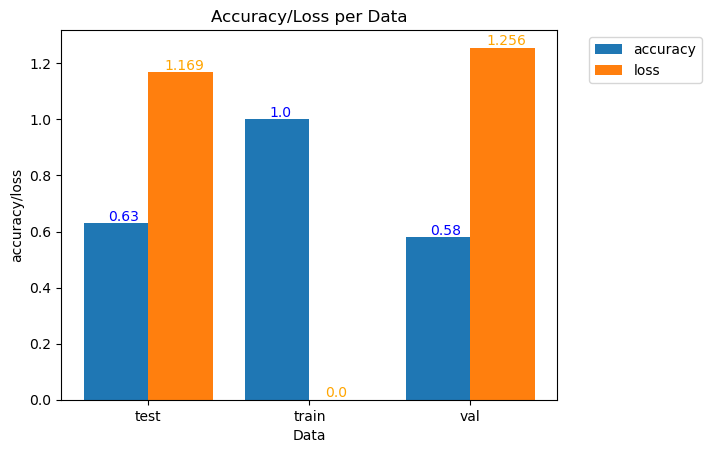

In [18]:
plot_scores(base_model, train_images, test_images, val_images, savefigname=None)

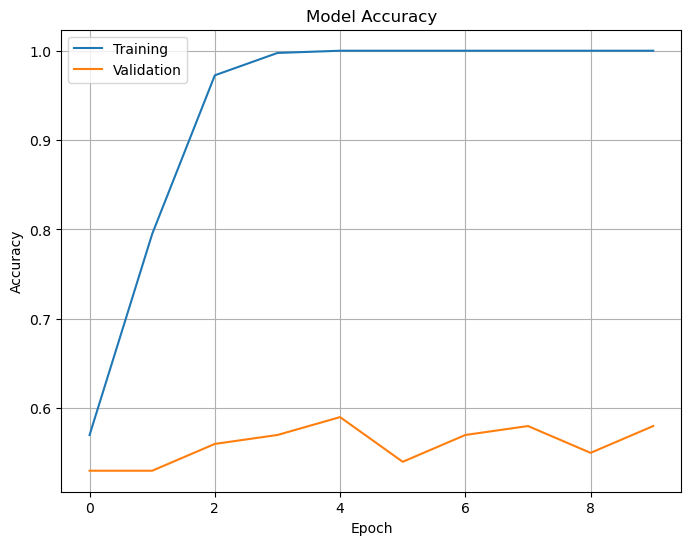

In [19]:
plot_acc_curve(trainHistory)

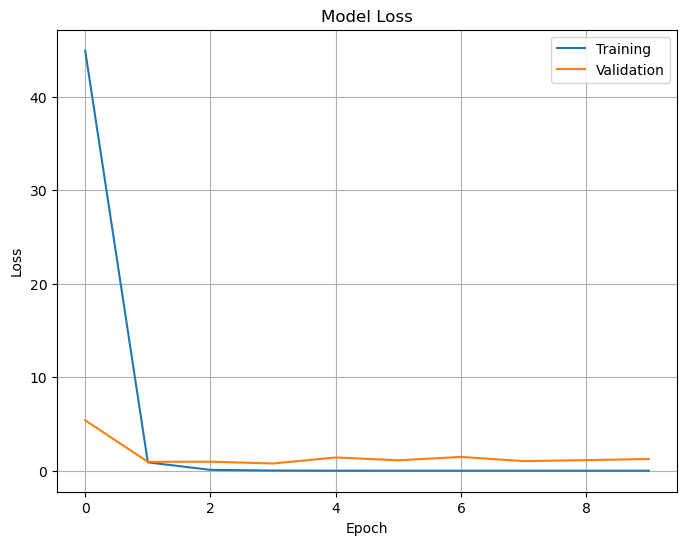

In [20]:
plot_loss_curve(trainHistory)

---

### Optimized - Dropout

> https://stackabuse.com/dont-use-flatten-global-pooling-for-cnns-with-tensorflow-and-keras/

In [24]:
optimized_model = tf.keras.Sequential([
    # Data augmentation
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(HEIGHT, WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.2),  # fraction of 2 pi
    #tf.keras.layers.RandomZoom(0.3),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(0.2),
    # Rest of Model
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2), (2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2), (2, 2)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimized_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 1250, 1250, 3)     0         
                                                                 
 random_rotation_1 (RandomRo  (None, 1250, 1250, 3)    0         
 tation)                                                         
                                                                 
 random_contrast_1 (RandomCo  (None, 1250, 1250, 3)    0         
 ntrast)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 1248, 1248, 32)    896       
                                                                 
 conv2d_7 (Conv2D)           (None, 1246, 1246, 32)    9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 623, 623, 32)    

In [26]:
trainHistory = optimized_model.fit(train_images, epochs=50, validation_data=val_images, verbose=0)

2023-06-12 18:31:20.695693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 18:31:44.337369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


test score:


2023-06-12 18:53:42.682135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 5s 1s/step - loss: 0.4828 - accuracy: 0.7800
train score:


2023-06-12 18:53:49.542497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 20s 1s/step - loss: 0.4404 - accuracy: 0.7850
val score:


2023-06-12 18:54:11.807234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step - loss: 0.5929 - accuracy: 0.7200


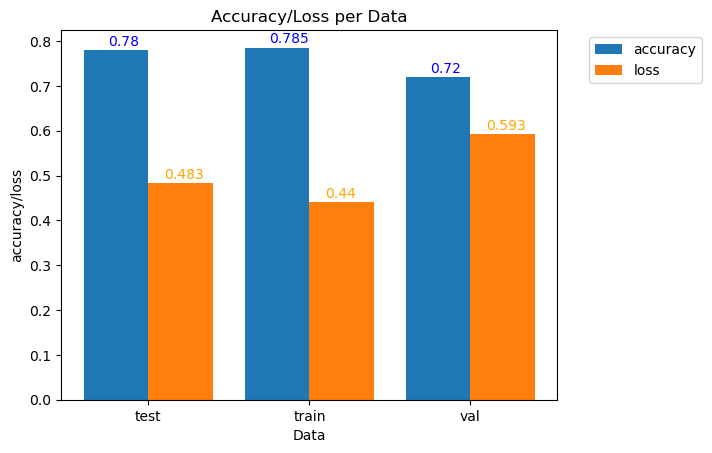

In [27]:
plot_scores(optimized_model, train_images, test_images, val_images, savefigname=None)

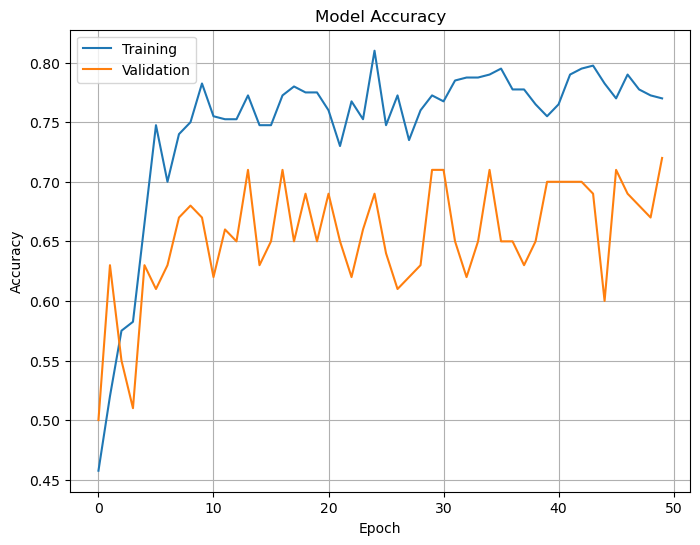

In [28]:
plot_acc_curve(trainHistory)

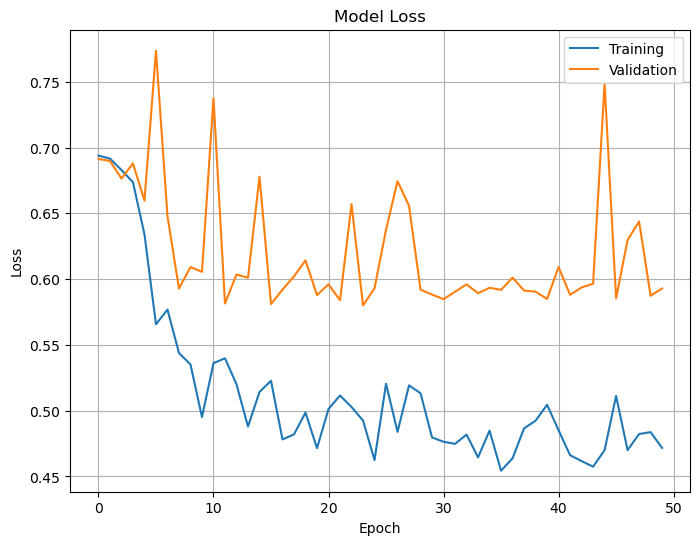

In [29]:
plot_loss_curve(trainHistory)

---

### Optimized simpler model with learning rate, data augmentation and global average pooling

In [30]:
optimized_model2 = tf.keras.Sequential([
    # Data augmentation
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(HEIGHT, WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.2),  # fraction of 2 pi
    #tf.keras.layers.RandomZoom(0.3),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(0.2),
    # Rest of Model
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimized_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
optimized_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 1250, 1250, 3)     0         
                                                                 
 random_rotation_2 (RandomRo  (None, 1250, 1250, 3)    0         
 tation)                                                         
                                                                 
 random_contrast_2 (RandomCo  (None, 1250, 1250, 3)    0         
 ntrast)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 1247, 1247, 16)    784       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 623, 623, 16)     0         
 2D)                                                             
                                                      

In [32]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=25, verbose=1, mode='max')
callbacks = [earlyStopping]

trainHistory = optimized_model2.fit(train_images, epochs=100, callbacks=callbacks, validation_data=val_images, verbose=0)

2023-06-12 18:54:19.654195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 18:54:20.295642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-12 18:54:50.694006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


test score:


2023-06-12 19:37:35.223463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 5s 1s/step - loss: 0.5205 - accuracy: 0.7500
train score:


2023-06-12 19:37:42.227842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 21s 1s/step - loss: 0.4759 - accuracy: 0.7950
val score:


2023-06-12 19:38:04.589568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 5s 1s/step - loss: 0.6452 - accuracy: 0.6300


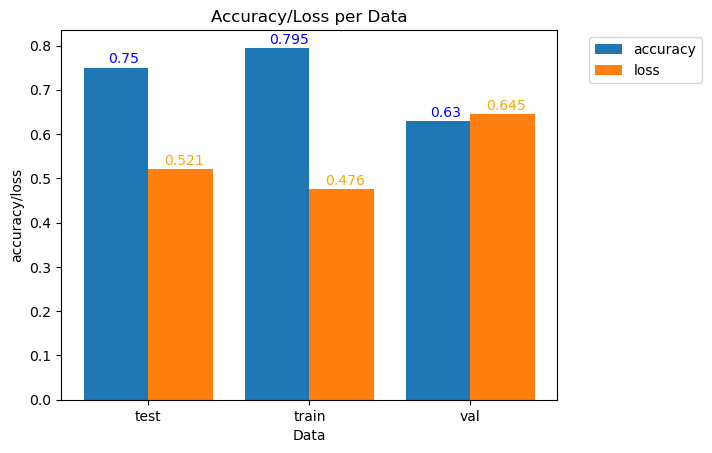

In [33]:
plot_scores(optimized_model2, train_images, test_images, val_images, savefigname=None)

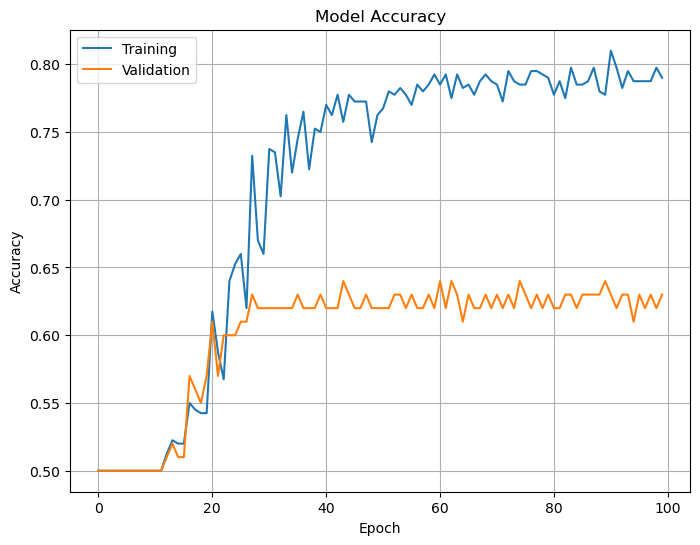

In [34]:
plot_acc_curve(trainHistory)

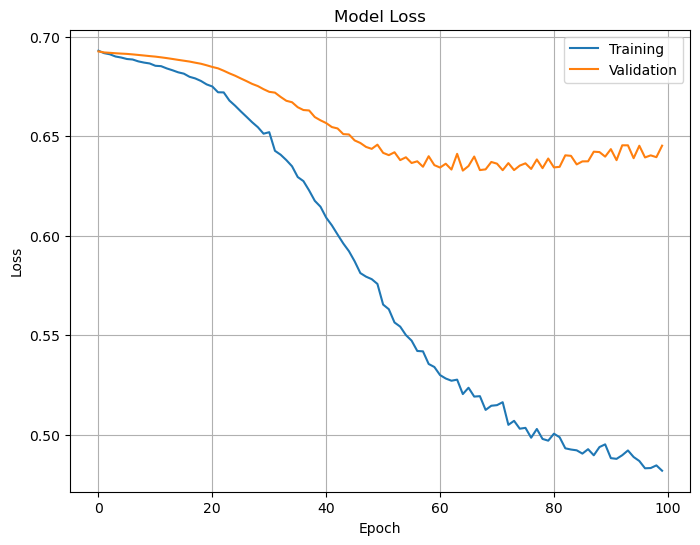

In [35]:
plot_loss_curve(trainHistory)

---

### Pretrained Model - Resnet50

> https://github.com/ozgunhaznedar/Hurricane-Damage-Detector---Image-Recognition/blob/main/Hurricane_Damage_Detector.ipynb

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)

In [37]:
model_name = "RESNET 50"
LR = 0.0001
initial_epoch = 30


base_model_resnet = tf.keras.applications.ResNet50(input_shape=(HEIGHT,WIDTH, 3),
                                            include_top=False,
                                            weights='imagenet')

base_model_resnet.trainable = False

image_batch, label_batch = next(iter(train_images))
feature_batch = base_model_resnet(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(HEIGHT,WIDTH, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model_resnet(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
base_model_resnet_final = tf.keras.Model(inputs, outputs)

base_model_resnet_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(base_model_resnet_final.summary())

trainHistory = base_model_resnet_final.fit(
  train_images,
  validation_data=val_images,
  callbacks=[es], 
  epochs=initial_epoch,
  verbose=0
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1250, 1250, 3)]   0         
                                                                 
 tf.__operators__.getitem (S  (None, 1250, 1250, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 1250, 1250, 3)    0         
                                                                 
 resnet50 (Functional)       (None, 40, 40, 2048)      23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               524544

2023-06-12 19:38:21.644003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 19:38:46.363399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


test score:


2023-06-12 19:51:45.102463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step - loss: 0.6239 - accuracy: 0.6700
train score:


2023-06-12 19:51:52.895035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 21s 1s/step - loss: 0.6037 - accuracy: 0.6775
val score:


2023-06-12 19:52:15.739904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step - loss: 0.5852 - accuracy: 0.7400


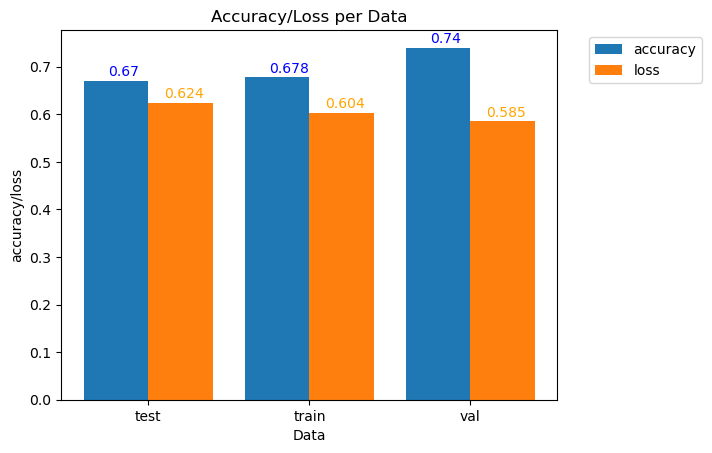

In [38]:
plot_scores(base_model_resnet_final, train_images, test_images, val_images, savefigname=None)

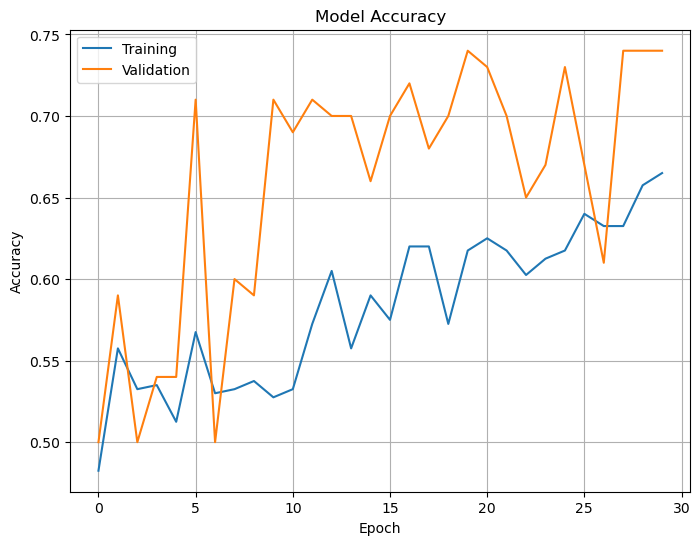

In [39]:
plot_acc_curve(trainHistory)

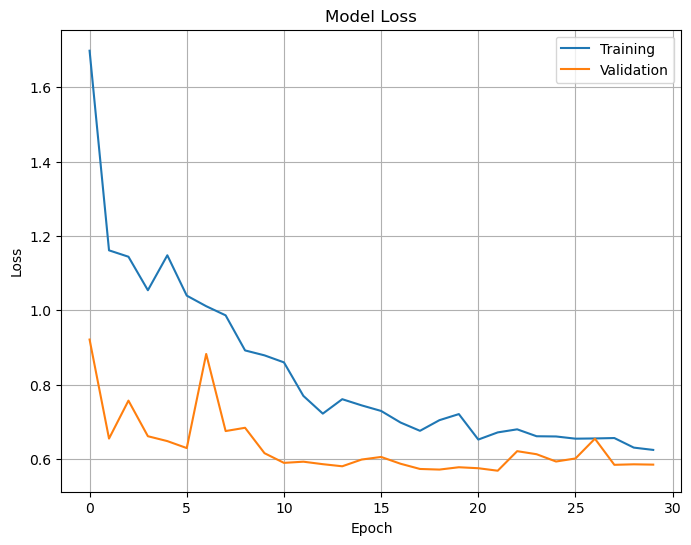

In [40]:
plot_loss_curve(trainHistory)

---

### Pretrained Model Tuned - Resnet50

In [41]:
model_name = "RESNET 50 Tuned"
LR = 0.0001
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs


base_model_resnet.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet.layers[:fine_tune_at]:
  layer.trainable = False


base_model_resnet_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(base_model_resnet_final.summary())

trainHistory2 = base_model_resnet_final.fit(
  train_images,
  validation_data=val_images,
  callbacks=[es], 
  initial_epoch = trainHistory.epoch[-1],
  epochs=total_epochs,
  verbose=0
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1250, 1250, 3)]   0         
                                                                 
 tf.__operators__.getitem (S  (None, 1250, 1250, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 1250, 1250, 3)    0         
                                                                 
 resnet50 (Functional)       (None, 40, 40, 2048)      23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               524544

2023-06-12 19:52:23.652090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 19:53:08.791735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Restoring model weights from the end of the best epoch: 50.
Epoch 70: early stopping


test score:


2023-06-12 20:11:15.038448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 7s 2s/step - loss: 0.6083 - accuracy: 0.7100
train score:


2023-06-12 20:11:23.359768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 22s 1s/step - loss: 0.6204 - accuracy: 0.6575
val score:


2023-06-12 20:11:46.652683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step - loss: 0.5672 - accuracy: 0.7400


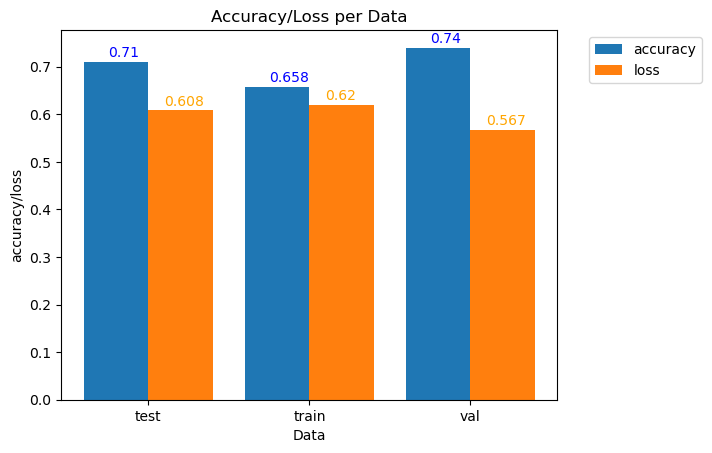

In [42]:
plot_scores(base_model_resnet_final, train_images, test_images, val_images, savefigname=None)

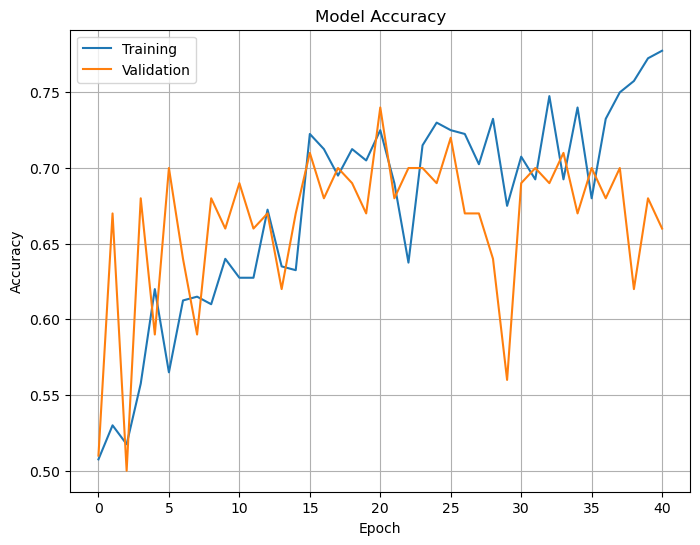

In [43]:
plot_acc_curve(trainHistory2)

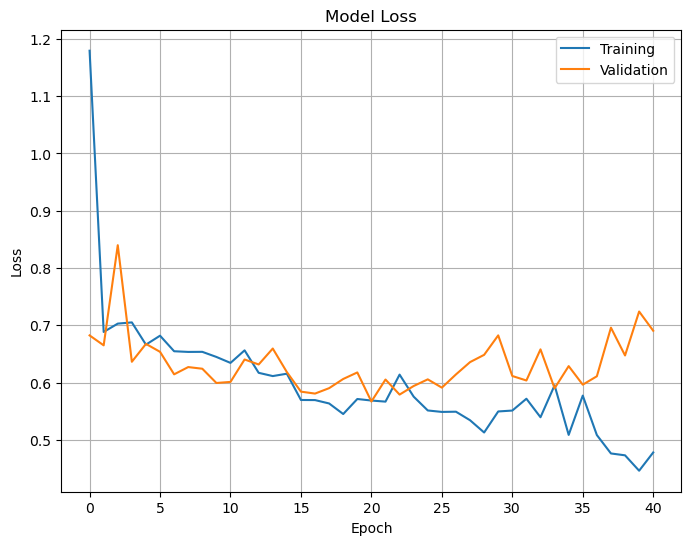

In [44]:
plot_loss_curve(trainHistory2)

---

### Konfusionsmatrix

> Funktioniert nur für Test/Validation Datensatz weil shuffle=False gesetzt ist im Image Generator

$Accuracy = \frac{(TP+TN)}{(TP+FP+FN+TN)}$

#### Base model

2023-06-12 20:12:14.328630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 1s/step


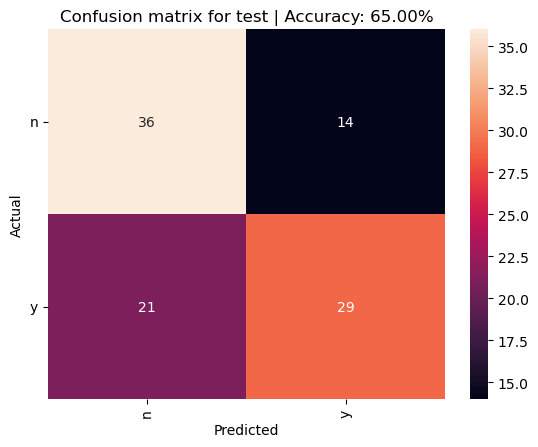

In [45]:
base_model = tf.keras.saving.load_model('base_model.h5')
class_labels = list(test_generator.class_indices)
actual, predicted = get_actual_predicted_labels(model=base_model, dataset=test_images)
plot_confusion_matrix(actual=actual, predicted=predicted, ds_type='test', labels=class_labels)

#### Optimized model

2023-06-12 20:12:21.952060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 6s 2s/step


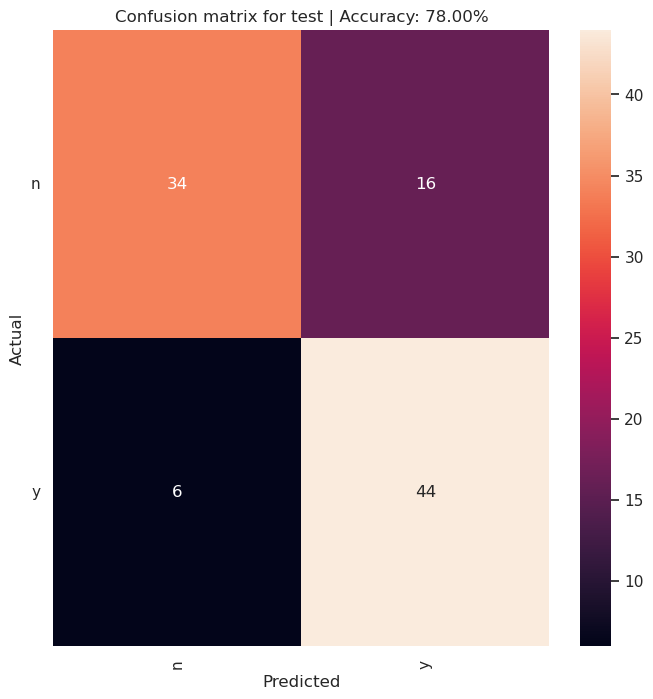

In [46]:
optimized_model = tf.keras.saving.load_model('optimized_model.h5')
class_labels = list(test_generator.class_indices)
actual, predicted = get_actual_predicted_labels(model=optimized_model, dataset=test_images)
plot_confusion_matrix(actual=actual, predicted=predicted, ds_type='test', labels=class_labels)

---

In [47]:
# save models
base_model.save('base_model.h5')
optimized_model.save('optimized_model.h5')
optimized_model2.save('optimized_model2.h5')
base_model_resnet_final.save('pretrained_model.h5')

ENDE